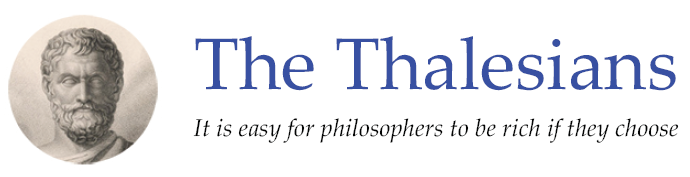

In [1]:
# Copyright (c) Thalesians Ltd, 2019. All rights reserved
# Copyright (c) Paul Alexander Bilokon, 2019. All rights reserved
# Author: Paul Alexander Bilokon <paul@thalesians.com>
# Version: 1.0 (2019.04.23)
# Email: education@thalesians.com
# Platform: Tested on Windows 10 with Python 3.6

# MCMC using PyMC3 for Stochastic Volatility with Leverage

## Motivation

Stochastic Volatility (SV) models with leverage (SVL) have been studies extensively in the literature, often as applications of particle filtering and Markov chain Monte Carlo (MCMC).

We shall demonstrate how the PyMC3 library can be used to calibrate SVL models with MCMC.

Note that this code constitutes a port of the models from [MY00] and [Yu05] from WinBUGS to PyMC3.

See [Bil16] for a more extensive bibliography: https://www.maths.ox.ac.uk/system/files/attachments/Bilokon.pdf

## Objectives

* To implement the SV model in PyMC3.
* To implement the SVL model in PyMC3.
* To demonstrate how these models can be calibrated.

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pymc3 as pm
import theano.tensor as tt

## Load the dataset

In [4]:
df1 = pd.read_csv('../../../data/dataset-1.csv')
y1 = df1['daily_log_return'].values

In [5]:
df2 = pd.read_csv('../../../data/dataset-2.csv')
y2 = df2['daily_log_return'].values

To use Dataset 1:

In [6]:
# log_returns = y1

To use Dataset 2:

In [7]:
log_returns = y2

## Implementation of the stochastic volatility model with leverage in PyMC3

In [8]:
class StochasticVolatilityProcess(pm.distributions.distribution.Continuous):
    def __init__(self, mu=None, phi=None, sigmav=None,
                 *args, **kwargs):
        super(StochasticVolatilityProcess, self).__init__(*args, **kwargs)
        self.alpha = pm.Deterministic('alpha', (1. - phi) * mu)
        self.phi = phi
        self.sigmav = sigmav
        self.init = pm.Normal.dist(mu=mu, sd=sigmav)
        self.mean = tt.as_tensor_variable(0.)

    def logp(self, x):
        alpha = self.alpha
        phi = self.phi
        sigmav = self.sigmav
        init = self.init

        x_im1 = x[:-1]
        x_i = x[1:]

        innov_like = pm.Normal.dist(mu=alpha + phi * x_im1, sd=sigmav).logp(x_i)
        return init.logp(x[0]) + tt.sum(innov_like)

    def _repr_latex_(self, name=None, dist=None):
        if dist is None:
            dist = self
        mu = dist.mu
        sd = dist.sd
        name = r'\text{%s}' % name
        return r'${} \sim \text{{StochasticVolatilityProcess}}(\mathit{{mu}}={},~\mathit{{sd}}={})$'.format(name,
                                                get_variable_name(mu),
                                                get_variable_name(sd))

In [9]:
def make_stochastic_volatility_model(model, log_returns):
    mu = pm.Normal(name='mu', mu=0., sd=np.sqrt(25.))
    phistar = pm.Beta(name='phistar', alpha=20., beta=1.5)
    recsigmav2 = pm.Gamma(name='recsigmav2', alpha=2.5, beta=.25)
    beta = pm.math.exp(pm.Deterministic('beta', .5 * mu))
    phi = pm.Deterministic('phi', 2. * phistar - 1.)
    sigmav = pm.Deterministic('sigmav', pm.math.sqrt(1. / recsigmav2))
    x = StochasticVolatilityProcess('x', mu, phi, sigmav, shape=len(log_returns) + 1)
    y = pm.Normal(name='y', mu=0., sd=pm.math.sqrt(pm.math.exp(x[1:])), observed=log_returns)

In [10]:
def make_stochastic_volatility_model_with_leverage(model, log_returns):
    mu = pm.Normal(name='mu', mu=0., sd=np.sqrt(25.))
    phistar = pm.Beta(name='phistar', alpha=20., beta=1.5)
    recsigmav2 = pm.Gamma(name='recsigmav2', alpha=2.5, beta=.25)
    beta = pm.math.exp(pm.Deterministic('beta', .5 * mu))
    phi = pm.Deterministic('phi', 2. * phistar - 1.)
    sigmav = pm.Deterministic('sigmav', pm.math.sqrt(1. / recsigmav2))
    rho = pm.Uniform(name='rho', lower=-1., upper=1.)
    x = StochasticVolatilityProcess('x', mu, phi, sigmav, shape=len(log_returns) + 2)
    y = pm.Normal(name='y',
                  mu=rho / sigmav * pm.math.exp(.5 * x[1:-1]) * (x[2:] - (1. - phi) * mu - phi * x[1:-1]),
                  sd=pm.math.sqrt(pm.math.exp(x[1:-1]) * (1 - rho * rho)),
                  observed=log_returns)

## Playing with the model

Let's apply the stochastic volatility model, no leverage:

Making model...
Sampling...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [x, recsigmav2, phistar, mu]
100%|██████████| 2500/2500 [06:53<00:00,  5.86it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Producing trace plot...


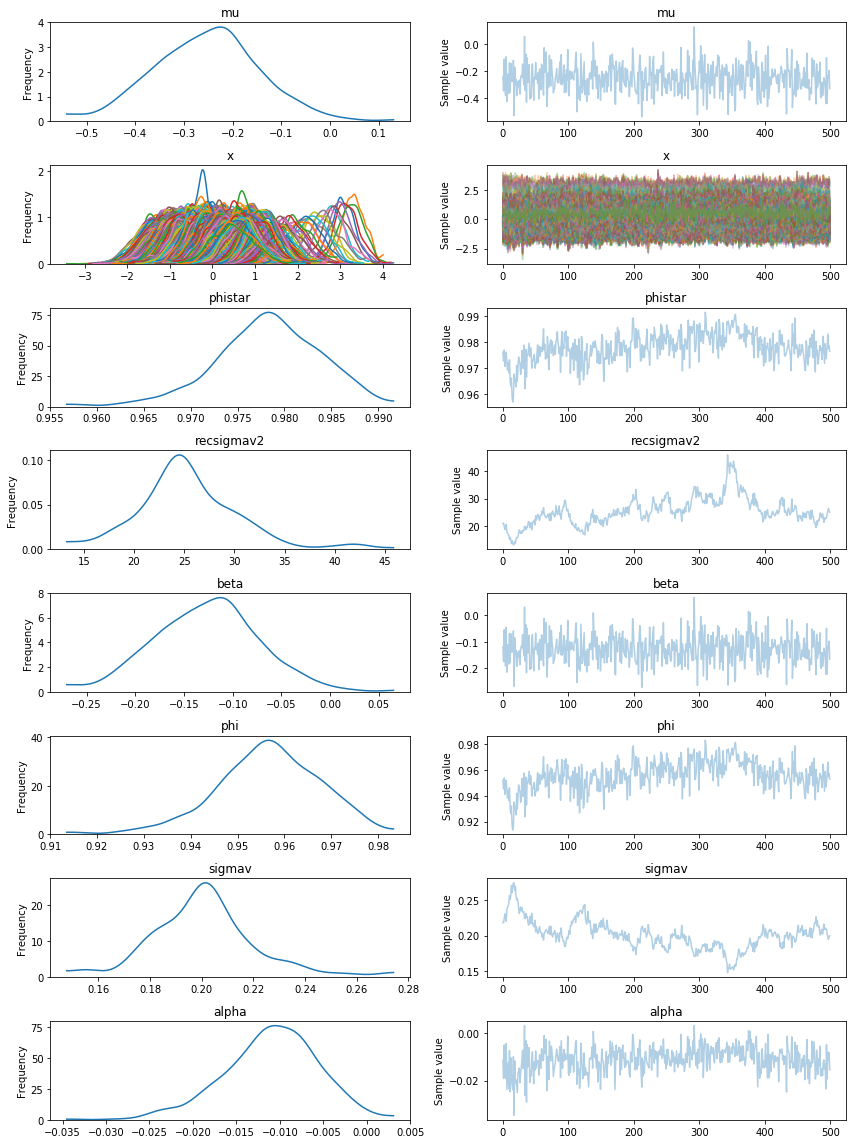

In [11]:
with pm.Model() as model:
    print('Making model...')
    make_stochastic_volatility_model(model, log_returns)
    print('Sampling...')
    trace = pm.sample(tune=2000, nuts_kwargs=dict(target_accept=.9), chains=1)
    print('Producing trace plot...')
    pm.traceplot(trace);

Let's apply the stochastic volatility model with leverage:

Making model...
Sampling...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [x, rho, recsigmav2, phistar, mu]
100%|██████████| 2500/2500 [10:53<00:00,  3.70it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


Producing trace plot...


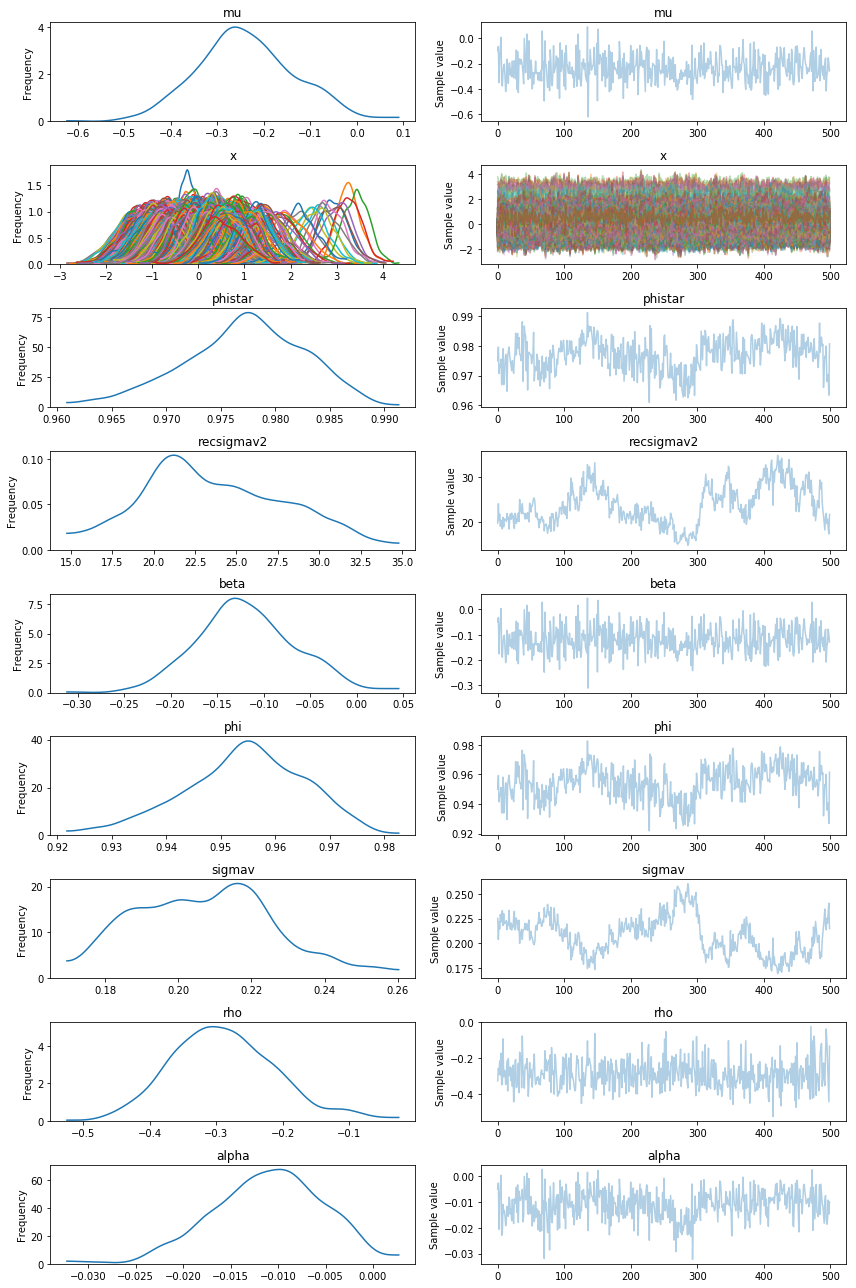

In [12]:
with pm.Model() as model:
    print('Making model...')
    make_stochastic_volatility_model_with_leverage(model, log_returns)
    print('Sampling...')
    trace = pm.sample(tune=2000, nuts_kwargs=dict(target_accept=.9), chains=1)
    print('Producing trace plot...')
    pm.traceplot(trace);

## Bibliography

**[Bil16]** Paul Bilokon. Bayesian methods for solving estimation and forecasting problems in the high-frequency trading environment. MSc thesis, University of Oxford, 2016.

**[DK00]** James Durbin and Siem Jan Koopman. Time series analysis of non-Gaussian observations based on state space models from both classical and Bayesian perspectives (with discussion). *Journal of the Royal Statistical Society, Series B*, 62:3-56, 2000.

**[HRS94]** Andrew C. Harvey, Esther Ruiz, and Neil Shephard. Multivariate stochastic variance models. *Review of Economic Studies*, 61:247-264, 1994.

**[KSC98]** Sangjoon Kim, Neil Shephard, and Siddhartha Chib. Stochastic volatility: Likelihood inference and comparison with ARCH models. *The Review of Economic Studies*, 65(3):361-393, July 1998.

**[MY00]** Renate Meyer and Jun Yu. BUGS for a Bayesian analysis of stochastic volatility models. *Econometrics Journal*, 3:198-215, 2000.

**[SP97]** Neil Shephard and Michael K. Pitt. Likelihood analysis of non-Gaussian measurement time series. *Biometrika*, 84:653-667, 1997.

**[Yu05]** Jun Yu. On leverage in a statistical volatility model. *Journal of Econometrics*, 127:165-178, 2005.